In [1]:
import numpy as np

import pycdcpd

%load_ext autoreload
%autoreload 2

In [2]:
for key in pycdcpd.__dict__.keys():
    print(key)

__name__
__doc__
__package__
__loader__
__spec__
PyCDCPD
CDCPDOutput
CDCPDIterationInputs
TrackingMap
DeformableObjectConfiguration
RopeConfiguration
DeformableObjectTracking
__file__


In [3]:
print(pycdcpd.__file__)
print(pycdcpd.__doc__)
print(pycdcpd.PyCDCPD.__dict__)

/home/dcolli23/catkin_ws/devel/lib/python3/dist-packages/pycdcpd.cpython-38-x86_64-linux-gnu.so
python bindings to cdcpd
{'__init__': <instancemethod __init__ at 0x7fafc8103160>, '__doc__': None, '__module__': 'pycdcpd', 'run': <instancemethod run at 0x7fafb93f7520>}


In [4]:
# cdcpd_runner = pycdcpd.PyCDCPD()

In [5]:
help(pycdcpd.PyCDCPD)

Help on class PyCDCPD in module pycdcpd:

class PyCDCPD(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      PyCDCPD
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: pycdcpd.PyCDCPD, tracking_map: TrackingMap, objective_value_threshold: float, use_recovery: bool, alpha: float, beta: float, lambda: float, k: float, zeta: float, obstacle_cost_weight: float, fixed_points_weight: float) -> None
 |  
 |  run(...)
 |      run(self: pycdcpd.PyCDCPD, arg0: CDCPDIterationInputs) -> CDCPD::Output
 |  
 |  ----------------------------------------------------------------------
 |  Static methods inherited from pybind11_builtins.pybind11_object:
 |  
 |  __new__(*args, **kwargs) from pybind11_builtins.pybind11_type
 |      Create and return a new object.  See help(type) for accurate signature.



In [6]:
help(pycdcpd.PyCDCPD.run)

Help on instancemethod in module pycdcpd:

run(...)
    run(self: pycdcpd.PyCDCPD, arg0: CDCPDIterationInputs) -> CDCPD::Output



## Try Defining A Rope Configuration

In [7]:
num_rope_points = 2
max_rope_length = 0.1
rope_start_position = np.array([0., 0., 0.])
rope_end_position = np.array([0.09, 0., 0.])
rope = pycdcpd.RopeConfiguration(num_rope_points, max_rope_length, rope_start_position, rope_end_position)
rope.initializeTracking()

## Try Defining TrackingMap And Adding Configurations To It

In [8]:
tracking_map = pycdcpd.TrackingMap()

In [9]:
print("Tracking Map At Beginning:", tracking_map.tracking_map)

tracking_map.add_def_obj_configuration(rope)

print("Tracking Map At End:", tracking_map.tracking_map)

Tracking Map At Beginning: {}
Tracking Map At End: {0: <pycdcpd.RopeConfiguration object at 0x7fafb9b02ab0>}


In [10]:
tracking_map.tracking_map[0].max_rope_length_

0.10000000149011612

In [11]:
# help(tracking_map.tracking_map[0])

In [12]:
print(tracking_map.tracking_map[0].tracked_.getVerticesCopy())

[[0.   0.09]
 [0.   0.  ]
 [0.   0.  ]]


<font color='green'>Success!</font>

## Try and Initialize CDCPD

In [13]:
# These are the default parameter values.
objective_value_threshold = 1.0
use_recovery = False
alpha = 0.5
beta = 1.0
lambda_arg = 1.0
k = 100.0
zeta = 10.0
obstacle_cost_weight = 0.001
fixed_points_weight = 10.0

cdcpd_runner = pycdcpd.PyCDCPD(tracking_map, objective_value_threshold, use_recovery, alpha, beta,
    lambda_arg, k, zeta, obstacle_cost_weight, fixed_points_weight)


Start form_edges_matrix
End form_edges_matrix
At least made it here!
End form_vertices_cloud
LLE begin
after setting input cloud
Cloud height: 1
Cloud width: 2
After assert
before loop
Loop done
after barycenter_kneighbors_graph
LLE end
Past initializer list
Cloud height: 1
Cloud width: 2
After assert
before loop
Loop done
Before CPD construction


## Populate the CDCPD Iteration Inputs

In [22]:
num_pts = 25
num_verts = 4
num_segments = 3


alg_input = pycdcpd.CDCPDIterationInputs()


# Things we'll have to specify.
alg_input.X = np.random.randn(3, num_pts) * 0.3  # The point cloud.
alg_input.pred_choice = 0  # Choice of dynamics model.
alg_input.tracking_map = tracking_map

# Things we need to construct but that aren't really problem dependent.
alg_input.Y_emit_prior = np.ones(num_verts, dtype=np.float32)  # Visibility prior.

# Things we don't have to specify
# alg_input.obstacle_constraints
# alg_input.pred_fixed_points
# alg_input.q_dot
# alg_input.q_config

## Try Running CDCPD For One Iteration

In [23]:
import time

start = time.time()
output = cdcpd_runner.run(alg_input)
end = time.time()
print("Took:", end - start)

Took: 0.0004162788391113281
At least made it here!
End form_vertices_cloud
At least made it here!
End form_vertices_cloud


In [16]:
output.get_cpd_output()

array([[-0.03524333,  0.05174401],
       [ 0.02446294,  0.00911152],
       [-0.01510979, -0.01305348]], dtype=float32)

In [17]:
output.get_gurobi_output()

array([[-0.03528748,  0.05178818],
       [ 0.02447075,  0.00910375],
       [-0.01511085, -0.01305245]], dtype=float32)

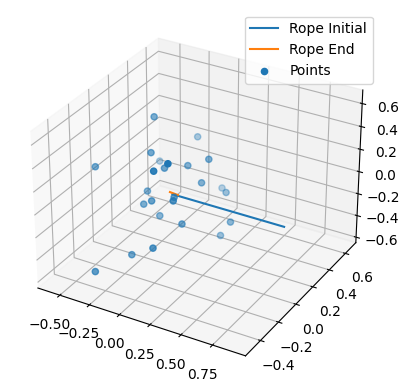

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x_0 = [0, 0.9]
y_0 = [0, 0]
z_0 = [0, 0]
ax.plot(x_0, y_0, z_0, label="Rope Initial")

gurobi_output = output.get_gurobi_output()
ax.plot(gurobi_output[0, :], gurobi_output[1, :], gurobi_output[2, :], label="Rope End")


ax.scatter(alg_input.X[0, :], alg_input.X[1, :], alg_input.X[2, :], label="Points")

ax.legend()

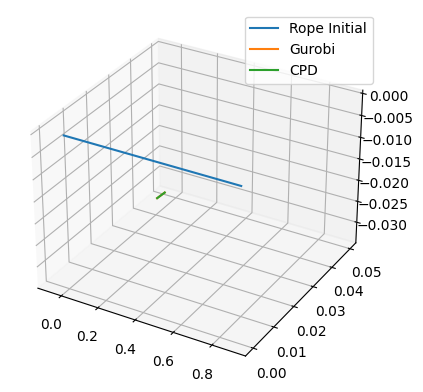

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x_0 = [0, 0.9]
y_0 = [0, 0]
z_0 = [0, 0]
ax.plot(x_0, y_0, z_0, label="Rope Initial")

gurobi_output = output.get_gurobi_output()
ax.plot(gurobi_output[0, :], gurobi_output[1, :], gurobi_output[2, :], label="Gurobi")

cpd_output = output.get_cpd_output()
ax.plot(cpd_output[0, :], cpd_output[1, :], cpd_output[2, :], label="CPD")

# ax.scatter(alg_input.X[0, :], alg_input.X[1, :], alg_input.X[2, :], label="Points")

ax.legend()